In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model, Sequential

## 1.- Preprocesamiento de los datos

In [3]:
fdata = pd.read_csv('data_histories.csv', index_col="dp_folio")
fdata.head()

,id_sexo,Aedad,AAedad,Apuesto,id_gestud,AIMC,fuma,fuma_act,ejer_act,ejer1,...,locout5,locout10,locout20,locout30,rest_act,rest1,rest5,rest10,rest20,rest30
dp_folio,,,,,,,,,,,,,,,,,,,,,
1,F,51,6,Admin,CarTec,4,1,3,0,2,...,1,1,1,1,0,0,0,0,0,0
2,F,38,4,Sec,Bach,3,2,-1,0,0,...,0,0,0,0,1,3,0,0,0,0
3,F,34,3,Int,Sec,5,1,1,0,0,...,1,-1,-1,-1,0,0,0,-1,-1,-1
4,M,63,8,Jef,CarTec,4,2,-1,2,2,...,0,0,0,-1,0,0,0,0,0,0
5,M,42,4,EM,Sec,3,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


### Funciones para clusterizar/discretizar los datos

In [4]:
#Function to clusterize categories of a certain feature, and add the new clusterized feature as a new column
# Clusters should be an input of the form {cluster_A: {categories}, cluster_B: [categories]}
# Ex. obesity = {0:[1,2,3], 1:[4,5,6]}
def clusterizeDiscrete(feature, clusters, new_name, data):
    new_data = data.copy()
    original_list = data.loc[1:1080, feature]
    new_list = []
    for index in original_list.index:
        cat = False
        if original_list[index] == -1 or original_list[index] == "-1":
            new_list.append("N")
            continue
        for cluster in clusters:
            if original_list[index] in clusters[cluster]:
                new_list.append(cluster)
                cat = True
        if cat == False:
            new_list.append("N")
    new_data[new_name] = new_list
    return new_data

# Function to clusterize categories of a certain continous feature, and add the new clusterized feature as a
# new column
# Clusters shoud be an input of the form {cluster_A: {lambdaFunction1}, cluster_B: lambdaFunction2}
def clusterizeContinuous(feature, clusters, new_name, data):
    new_data = data.copy()
    original_list = data.loc[1:1080, feature]
    new_list = []
    for index in original_list.index:
        if original_list[index] == -1 or original_list[index] == "-1":
            new_list.append("N")
            continue
        for cluster in clusters:
            if eval(clusters[cluster])(original_list[index]):
                new_list.append(cluster)
                break
    new_data[new_name] = new_list
    return new_data
        

# Set of auxiliary high-order functions that will evaluate the conditions to binarize a history
def lessThan(num):
    return lambda n: n < num

def lessQThan(num):
    return lambda n: n <= num

def greaterThan(num):
    return lambda n: n > num

def greaterQThan(num):
    return lambda n: n >= num

def between(num1, num2):
    return lambda n: n <= num2 and n >= num1

### Definición y creación de los clusters

In [5]:
# Clusterize between obese and non obese
obesity = {0:[1,2,3], 1:[4,5,6]}
ndata = clusterizeDiscrete("AIMC", obesity, "obesity", fdata)

# Clusterize between degrees of study (higher degree vs. non higher degree)
degree = {0:["Prim", "Sec", "Bach", "CarTec", "Otro"], 1:["Lic", "Mast", "Doc", "PDoc"]}
ndata = clusterizeDiscrete("id_gestud", degree, "hdegree", ndata)

# Clusterize excercise features
ejer = {"A":"greaterQThan(2.5)", "B":"lessThan(2.5)"}
ndata = clusterizeContinuous("ejer_act", ejer, "ejer0B", ndata)
ndata = clusterizeContinuous("ejer1", ejer, "ejer1B", ndata)
ndata = clusterizeContinuous("ejer5", ejer, "ejer5B", ndata)
ndata = clusterizeContinuous("ejer10", ejer, "ejer10B", ndata)
ndata = clusterizeContinuous("ejer20", ejer, "ejer20B", ndata)
ndata = clusterizeContinuous("ejer30", ejer, "ejer30B", ndata)

# Clusterize stress features
estres = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("estres_act", estres, "estres0B", ndata)
ndata = clusterizeDiscrete("estres1", estres, "estres1B", ndata)
ndata = clusterizeDiscrete("estres5", estres, "estres5B", ndata)
ndata = clusterizeDiscrete("estres10", estres, "estres10B", ndata)
ndata = clusterizeDiscrete("estres20", estres, "estres20B", ndata)
ndata = clusterizeDiscrete("estres30", estres, "estres30B", ndata)

# Clusterize weight features
peso = {"A":[1,2,3], "B":[4,5]}
ndata = clusterizeDiscrete("peso_act", peso, "peso0B", ndata)
ndata = clusterizeDiscrete("peso1", peso, "peso1B", ndata)
ndata = clusterizeDiscrete("peso5", peso, "peso5B", ndata)
ndata = clusterizeDiscrete("peso10", peso, "peso10B", ndata)
ndata = clusterizeDiscrete("peso20", peso, "peso20B", ndata)
ndata = clusterizeDiscrete("peso30", peso, "peso30B", ndata)

# Clusterize weight features
condi = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("condi_act", condi, "condi0B", ndata)
ndata = clusterizeDiscrete("condi1", condi, "condi1B", ndata)
ndata = clusterizeDiscrete("condi5", condi, "condi5B", ndata)
ndata = clusterizeDiscrete("condi10", condi, "condi10B", ndata)
ndata = clusterizeDiscrete("condi20", condi, "condi20B", ndata)
ndata = clusterizeDiscrete("condi30", condi, "condi30B", ndata)

# Clusterize health features
salud = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("salud_act", salud, "salud0B", ndata)
ndata = clusterizeDiscrete("salud1", salud, "salud1B", ndata)
ndata = clusterizeDiscrete("salud5", salud, "salud5B", ndata)
ndata = clusterizeDiscrete("salud10", salud, "salud10B", ndata)
ndata = clusterizeDiscrete("salud20", salud, "salud20B", ndata)
ndata = clusterizeDiscrete("salud30", salud, "salud30B", ndata)

# Clusterize job features
academic = {0:["Admin", "Asi", "Coo", "E", "ED", "EM", "Int", "Jef", "Lab", "Sec", "Tec", "Vig"], 1:["Acade", "Inv", "InvE"]}
ndata = clusterizeDiscrete("Apuesto", academic, "academic", ndata)

# Clusterize walking features
walking = {"A":"greaterQThan(1800.0)", "B":"lessThan(1800.0)"}
ndata = clusterizeContinuous("dis_dia", walking, "dis_dia0B", ndata)
ndata = clusterizeContinuous("dis1_dia", walking, "dis_dia1B", ndata)
ndata = clusterizeContinuous("dis5_dia", walking, "dis_dia5B", ndata)
ndata = clusterizeContinuous("dis10_dia", walking, "dis_dia10B", ndata)
ndata = clusterizeContinuous("dis20_dia", walking, "dis_dia20B", ndata)
ndata = clusterizeContinuous("dis30_dia", walking, "dis_dia30B", ndata)


# Clusterize age features
age = {0:"between(15.0, 28.0)", 1:"between(28.1, 40.0)", 2:"between(40.1, 60.0)", 3:"between(60.1, 90.0)"}
ndata = clusterizeContinuous("Aedad", age, "AedadC", ndata)

In [6]:
ndata.head()

,id_sexo,Aedad,AAedad,Apuesto,id_gestud,AIMC,fuma,fuma_act,ejer_act,ejer1,...,salud20B,salud30B,academic,dis_dia0B,dis_dia1B,dis_dia5B,dis_dia10B,dis_dia20B,dis_dia30B,AedadC
dp_folio,,,,,,,,,,,,,,,,,,,,,
1,F,51,6,Admin,CarTec,4,1,3,0,2,...,A,A,0,B,B,A,N,N,N,2
2,F,38,4,Sec,Bach,3,2,-1,0,0,...,A,A,0,A,B,B,B,A,B,1
3,F,34,3,Int,Sec,5,1,1,0,0,...,A,N,0,B,B,B,B,B,B,1
4,M,63,8,Jef,CarTec,4,2,-1,2,2,...,A,A,0,A,A,A,A,A,A,3
5,M,42,4,EM,Sec,3,1,2,2,2,...,N,N,0,B,B,B,N,N,N,2


### Creación de la matriz de variables (features)

In [7]:
# Build profile based on excercise, health and stress in the last 0, 1, 5 and 10 years
profiles_0_to_10 = ndata[["ejer0B", "salud0B", "estres0B", "ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B"]]
profiles_1_to_10 = ndata[["ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B"]]

# Replace "A" with 1, and "B" with 0, in order to have binary values, and save this in the feature matrix X
X_0 = profiles_0_to_10.replace("A", 1).replace("B", 0).replace("N", 0)
X_1 = profiles_1_to_10.replace("A", 1).replace("B", 0).replace("N", 0)

In [8]:
X_0.head()

,ejer0B,salud0B,estres0B,ejer1B,salud1B,estres1B,ejer5B,salud5B,estres5B,ejer10B,salud10B,estres10B
dp_folio,,,,,,,,,,,,
1,0,1,1,0,1,0,0,1,1,0,1,0
2,0,1,0,0,1,0,1,0,1,1,1,0
3,0,0,1,0,0,1,0,1,1,1,1,1
4,0,1,0,0,1,1,1,1,0,1,1,0
5,0,1,0,0,1,0,0,0,0,0,0,1


## 2.- RBM

In [9]:
# Simple function to split a set between batches
def batch_iterator(X, y=None, batch_size=64):
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

In [43]:
# Classic Restricted Boltzmann Machine
class RBM :
    
    def __init__(self, num_visible, num_hidden, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.W = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.a = np.zeros(num_visible)
        self.b = np.zeros(num_hidden)
    
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        # Positive phase: Calculate the activations of the hidden layer
        positive_hidden = self.sigmoid(X.dot(self.W) + self.b)
        hidden_states = self.sample(positive_hidden)
        # Negative phase: Given the activations of the hidden layer, reconstruct the states at the visible layer
        negative_visible = self.sigmoid(hidden_states.dot(self.W.T) + self.a)
        visible_states = self.sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        return self.sigmoid(X.dot(self.W) + self.b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                V = np.array(batch.values)
                
                # Positive phase: Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + self.b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden states activations, rather than their probabilities
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Negative phase
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + self.a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + self.b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states activations
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                
                batch_errors.append(np.mean((batch - negative_visible_states) ** 2))
                                    
            self.training_errors.append(np.mean(batch_errors))
                

In [46]:
rbm = RBM(12, 100, 0.001, 10, 100)

In [47]:
rbm.train(X_0)

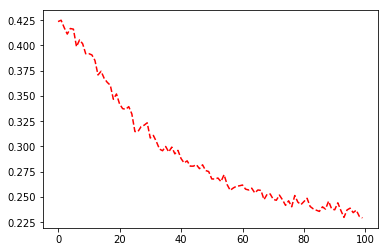

In [48]:
t = np.arange(0, 100, 1)
plt.plot(t, rbm.training_errors, 'r--')
plt.show()

In [28]:
print X_0.iloc[0].values
print rbm.transform(X_0.iloc[0])
print rbm.gibbs_sample(X_0.iloc[0])

[0 1 1 0 1 0 0 1 1 0 1 0]
[0.57848525 0.4756864  0.41280444 0.33395268 0.45335738 0.55960095
 0.51457108 0.5709925  0.5638379  0.51397068 0.54895453 0.43003909
 0.41918574 0.5358265  0.44784826 0.63573682 0.41519828 0.52812639
 0.52386702 0.69119996 0.51399734 0.63868195 0.46055899 0.42130848
 0.61523364 0.50265577 0.69977397 0.57832065 0.32345989 0.43276711
 0.63136718 0.60154086 0.49729503 0.51808668 0.56053446 0.50373438
 0.43351124 0.29394856 0.48390552 0.57307467 0.60478409 0.46386232
 0.41624265 0.44609099 0.44395264 0.61451547 0.51250637 0.50777924
 0.49554745 0.67163928 0.46183    0.46012649 0.44042952 0.55701273
 0.54183922 0.57399607 0.51709854 0.39395971 0.38289547 0.51651381
 0.52490159 0.47095612 0.40554595 0.63683551 0.43156101 0.43781999
 0.53674438 0.65361527 0.4953639  0.60053596 0.44789595 0.39961372
 0.39517276 0.50429042 0.53982233 0.467738   0.42036786 0.47304182
 0.57736681 0.3853474  0.65447788 0.53823755 0.45387407 0.64782638
 0.47025622 0.49851912 0.47060929 0.

## 3.- CRBM

In [29]:
# Conditional / Temporally Restricted Boltzmann Machine
class CRBM :
    
    def __init__(self, num_visible, num_hidden, num_historic, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.num_historic = num_historic
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        # Initialize weights and biases
        self.W = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.a = np.zeros(num_visible)
        self.b = np.zeros(num_hidden)
        
        # Initialize autoregreesive parameters
        self.A = np.random.normal(scale=0.01, size=(num_visible, num_historic))
        self.B = np.random.normal(scale=0.01, size=(num_hidden, num_historic))
    
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        
        # Separate input vector
        V = np.array(X.values[:, :3])
        H = np.array(X.values[:, 3:])

        # Positive phase

        # Calculate the contributions from the Historic layer
        dinamic_b = self.b + H.dot(self.B.T)

        # Calculate the activations of the Hidden layer
        positive_hidden = sigmoid(V.dot(self.W) + dinamic_b)
        hidden_states = sample(positive_hidden)

        # Negative phase

        #Calculate the contributions from the Historic layer
        dinamic_a = self.a + H.dot(self.A.T)
        
        # Calculate the activations of the Visible layer
        negative_visible = sigmoid(hidden_states.dot(self.W.T) + dinamic_a)
        visible_states = sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        V = np.array(X.values[:, :3])
        H = np.array(X.values[:, 3:])
        dinamic_b = self.b + H.dot(self.B.T)
        return self.sigmoid(V.dot(self.W) + dinamic_b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                # Separate input vector
                V = np.array(batch.values[:, :3])
                H = np.array(batch.values[:, 3:])
                
                
                # Positive phase
                # Calculate the contributions from the Historic layer
                dinamic_b = self.b + H.dot(self.B.T)
                
                # Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + dinamic_b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden probabilities, rather than their activations
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Calculate vH_data (H: Historic layer)
                vH_data = V.T.dot(H)
                # Calculate hH_data (H: Historic layer)
                hH_data = positive_hidden_states.T.dot(H)
                
                
                
                # Negative phase
                
                # Calculate the contributions from the Historic layer
                dinamic_a = self.a + H.dot(self.A.T)
                
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + dinamic_a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + dinamic_b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states probabilities
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Calculate vH_reconstruction (H: Historic layer)
                vH_reconstruction = negative_visible_states.T.dot(H)
                # Calculate hH_reconstruction (H: Historic layer)
                hH_reconstruction = negative_hidden_states.T.dot(H)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                self.B += self.learning_rate * 0.01 * (hH_data - hH_reconstruction)
                self.A += self.learning_rate * 0.01 * (vH_data - vH_reconstruction)
                
                batch_errors.append(np.mean((V - negative_visible_states) ** 2))
            #print "Epoch " + str(epoch) + " - MSE: " + str(np.mean(batch_errors))                        
            self.training_errors.append(np.mean(batch_errors))
                

In [112]:
crbm = CRBM(3, 100, 9, 0.001, 10, 1000)

In [113]:
crbm.train(X_0)

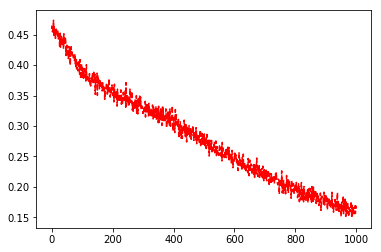

In [114]:
t = np.arange(0, 1000, 1)
plt.plot(t, crbm.training_errors, 'r--')
plt.show()

In [105]:
crbm.transform(X_0).shape

(1076, 100)

## 4.- SRBM

In [30]:
# Socially Restricted Boltzmann Machine
class SRBM :
    
    def __init__(self, num_visible, num_hidden, num_historic, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.num_historic = num_historic
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Initialize parameters
    def initialize(self):
        # Initialize weights and biases
        self.W = np.random.normal(scale=0.1, size=(self.num_visible, self.num_hidden))
        self.a = np.zeros(self.num_visible)
        self.b = np.zeros(self.num_hidden)
        
        # Initialize autoregreesive parameters
        self.A = np.random.normal(scale=0.01, size=(self.num_visible, self.num_historic))
        self.B = np.random.normal(scale=0.01, size=(self.num_hidden, self.num_historic))
    
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        
        # Create Historic layer
        H = np.tile(self.historic, (len(X), 1))
        
        # Separate input vector
        V = np.array(X.values[:, :3])

        # Positive phase

        # Calculate the contributions from the Historic layer
        dinamic_b = self.b + H.dot(self.B.T)

        # Calculate the activations of the Hidden layer
        positive_hidden = sigmoid(V.dot(self.W) + dinamic_b)
        hidden_states = sample(positive_hidden)

        # Negative phase

        #Calculate the contributions from the Historic layer
        dinamic_a = self.a + H.dot(self.A.T)
        
        # Calculate the activations of the Visible layer
        negative_visible = sigmoid(hidden_states.dot(self.W.T) + dinamic_a)
        visible_states = sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        # Separate input vector
        V = np.array(X.values[:, :3])
        # Create Historic layer
        H = np.tile(self.historic, (len(X), 1))
        dinamic_b = self.b + H.dot(self.B.T)
        return self.sigmoid(V.dot(self.W) + dinamic_b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        self.historic = []
        for id in X.values[:, 3:]:
            for value in id:
                self.historic.append(value)
                
        self.num_historic = len(self.historic)
        self.initialize()
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                # Separate input vector
                V = np.array(batch.values[:, :3])   
                
                # Create Historic layer
                H = np.tile(self.historic, (len(batch), 1))
                #print H.shape
                
                # Positive phase
                # Calculate the contributions from the Historic layer
                dinamic_b = self.b + H.dot(self.B.T)
                
                # Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + dinamic_b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden probabilities, rather than their activations
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Calculate vH_data (H: Historic layer)
                vH_data = V.T.dot(H)
                # Calculate hH_data (H: Historic layer)
                hH_data = positive_hidden_states.T.dot(H)
                
                
                
                # Negative phase
                
                # Calculate the contributions from the Historic layer
                dinamic_a = self.a + H.dot(self.A.T)
                
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + dinamic_a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + dinamic_b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states probabilities
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Calculate vH_reconstruction (H: Historic layer)
                vH_reconstruction = negative_visible_states.T.dot(H)
                # Calculate hH_reconstruction (H: Historic layer)
                hH_reconstruction = negative_hidden_states.T.dot(H)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                self.B += self.learning_rate * 0.001 * (hH_data - hH_reconstruction)
                self.A += self.learning_rate * 0.001 * (vH_data - vH_reconstruction)
                #print dinamic_a
                #print H.dot(self.A.T).sum()
                #print dinamic_b
                
                batch_errors.append(np.mean((V - negative_visible_states) ** 2))
            print "Epoch " + str(epoch) + " - MSE: " + str(np.mean(batch_errors))                        
            self.training_errors.append(np.mean(batch_errors))
                

In [32]:
srbm = SRBM(3, 200, 9684, 0.001, 10, 50)

In [147]:
srbm.train(X_0)

Epoch 0 - MSE: 0.425514403292181


KeyboardInterrupt: 

## 5.- Autoencoder

In [57]:
dim = X_1.shape[-1]
encoding_dim = 8

# Define the input layer
inputs = Input(shape=(dim,))

# Define the encoding layer (turns inputs into an encoded representation)
encoded = Dense(encoding_dim, activation='relu')(inputs)

# Define the decoding layer (turns the encoded representation into a decoded output)
decoded = Dense(dim, activation='sigmoid')(encoded)

# Define the autoencoder
autoencoder = Model(inputs, decoded)

# Define the encoder (this will be used for the classification purposes)
encoder = Model(inputs, encoded)

In [58]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [59]:
# Train the autoencoder
autoencoder.fit(X_1, X_1, epochs=500, batch_size=10)

Epoch 1/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.6733
Epoch 2/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.6066
Epoch 3/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.5435
Epoch 4/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.4898
Epoch 5/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.4389
Epoch 6/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.3923
Epoch 7/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.3521
Epoch 8/500
1076/1076 [==============================] - 0s 33us/step - loss: 0.3184
Epoch 9/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.2909
Epoch 10/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.2678
Epoch 11/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.2481
Epoch 12/500
1076/1076 [==============================] - 0s 29

1076/1076 [==============================] - 0s 27us/step - loss: 0.0109
Epoch 97/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0108
Epoch 98/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0107
Epoch 99/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0107
Epoch 100/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0105
Epoch 101/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0105
Epoch 102/500
1076/1076 [==============================] - 0s 26us/step - loss: 0.0104
Epoch 103/500
1076/1076 [==============================] - 0s 26us/step - loss: 0.0102
Epoch 104/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0102
Epoch 105/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0101
Epoch 106/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0100
Epoch 107/500
1076/1076 [==============================] - 0

1076/1076 [==============================] - 0s 30us/step - loss: 0.0071
Epoch 191/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0071
Epoch 192/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0070
Epoch 193/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0070
Epoch 194/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0070
Epoch 195/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0070
Epoch 196/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0070
Epoch 197/500
1076/1076 [==============================] - 0s 32us/step - loss: 0.0069
Epoch 198/500
1076/1076 [==============================] - 0s 26us/step - loss: 0.0070
Epoch 199/500
1076/1076 [==============================] - 0s 25us/step - loss: 0.0068
Epoch 200/500
1076/1076 [==============================] - 0s 46us/step - loss: 0.0068
Epoch 201/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 29us/step - loss: 0.0056
Epoch 285/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0057
Epoch 286/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0057
Epoch 287/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0056
Epoch 288/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0056
Epoch 289/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0056
Epoch 290/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0056
Epoch 291/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0056
Epoch 292/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0056
Epoch 293/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0056
Epoch 294/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0056
Epoch 295/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 27us/step - loss: 0.0036
Epoch 379/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0036
Epoch 380/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0036
Epoch 381/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0036
Epoch 382/500
1076/1076 [==============================] - 0s 35us/step - loss: 0.0035
Epoch 383/500
1076/1076 [==============================] - 0s 36us/step - loss: 0.0035
Epoch 384/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0035
Epoch 385/500
1076/1076 [==============================] - 0s 32us/step - loss: 0.0034
Epoch 386/500
1076/1076 [==============================] - 0s 33us/step - loss: 0.0034
Epoch 387/500
1076/1076 [==============================] - 0s 35us/step - loss: 0.0034
Epoch 388/500
1076/1076 [==============================] - 0s 32us/step - loss: 0.0034
Epoch 389/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 24us/step - loss: 0.0021
Epoch 473/500
1076/1076 [==============================] - 0s 25us/step - loss: 0.0020
Epoch 474/500
1076/1076 [==============================] - 0s 25us/step - loss: 0.0020
Epoch 475/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0020
Epoch 476/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0020
Epoch 477/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0020
Epoch 478/500
1076/1076 [==============================] - 0s 34us/step - loss: 0.0020
Epoch 479/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0020
Epoch 480/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0019
Epoch 481/500
1076/1076 [==============================] - 0s 35us/step - loss: 0.0020
Epoch 482/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0020
Epoch 483/500
1076/1076 [==============================] 

In [60]:
encoded_X = encoder.predict(X_1)
decoded_X = autoencoder.predict(X_1)

In [61]:
encoded_X

array([[ 8.709091 ,  5.790921 ,  1.1973302, ...,  9.605028 ,  1.9509504,
         5.025324 ],
       [ 1.904675 ,  9.385513 ,  2.0749502, ...,  2.4012778,  2.483448 ,
         6.3555927],
       [ 9.254468 , 16.746943 ,  7.0715857, ...,  7.227652 ,  6.2243414,
        10.159301 ],
       ...,
       [ 1.8940268,  8.467003 ,  1.4861035, ...,  9.0100565,  2.9941635,
         8.539642 ],
       [12.575961 ,  5.3498306,  3.6036448, ...,  5.7820563,  1.7884467,
         8.240598 ],
       [ 8.350746 , 17.541967 ,  1.7899375, ...,  4.5631604,  5.3517723,
         5.504404 ]], dtype=float32)

In [62]:
decoded_X

array([[3.9956635e-06, 9.9836522e-01, 2.8181188e-03, ..., 2.0754749e-08,
        1.0000000e+00, 1.3804424e-04],
       [2.9709591e-03, 7.7000701e-01, 4.4962323e-01, ..., 1.0000000e+00,
        1.0000000e+00, 7.6139703e-02],
       [1.7986017e-11, 2.3140159e-05, 9.9996400e-01, ..., 1.0000000e+00,
        1.0000000e+00, 9.9997425e-01],
       ...,
       [1.0000000e+00, 1.0000000e+00, 2.6391334e-09, ..., 1.0000000e+00,
        1.0000000e+00, 6.8325448e-07],
       [1.5254655e-09, 1.0000000e+00, 1.0000000e+00, ..., 1.0656968e-08,
        1.0000000e+00, 5.2374234e-09],
       [2.9977906e-07, 2.2893548e-07, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 6.1699005e-08]], dtype=float32)

In [63]:
print decoded_X[0]
print X_1.iloc[0]

[3.9956635e-06 9.9836522e-01 2.8181188e-03 4.6492643e-11 1.0000000e+00
 9.9644971e-01 2.0754749e-08 1.0000000e+00 1.3804424e-04]
ejer1B       0
salud1B      1
estres1B     0
ejer5B       0
salud5B      1
estres5B     1
ejer10B      0
salud10B     1
estres10B    0
Name: 1, dtype: int64


## 6.- Predicción de Obesidad

In [34]:
# Libraries for ROC plots
from scipy import interp
from sklearn.metrics import roc_curve, auc

# Libraries for Cross Validation
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

# Libraries for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [35]:
# Build profile based on excercise, health and stress in the last 0, 1, 5 and 10 years
profiles_0_to_10_wO = ndata[["ejer0B", "salud0B", "estres0B", "ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B", "obesity"]]
profiles_1_to_10_wO = ndata[["ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B", "obesity"]]


# Replace "A" with 1, and "B" with 0, in order to have binary values, and save this in the feature matrix X
X_Full = profiles_1_to_10_wO.replace("A", 1).replace("B", 0).replace("N", 0)

In [36]:
X_Full.iloc[:, :-1].head()

,ejer1B,salud1B,estres1B,ejer5B,salud5B,estres5B,ejer10B,salud10B,estres10B
dp_folio,,,,,,,,,
1,0,1,0,0,1,1,0,1,0
2,0,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,1,1,1
4,0,1,1,1,1,0,1,1,0
5,0,1,0,0,0,0,0,0,1


In [37]:
kf = KFold(n_splits = 5, shuffle=True)

In [38]:
for train_index, test_index in kf.split(X_Full):
    train = []
    test = []
    for index in train_index:
        train.append(X_Full.iloc[index])
    train = np.array(train)
    for index in test_index:
        test.append(X_Full.iloc[index])
    test = np.array(test)

In [50]:
rbm.transform(train[:, :-1]).shape
#X_Full.iloc[:, -1:].shape
#train[:, -1:].flatten()

(861, 100)

In [39]:
# Perform a 5-fold cross validation for a chosen model
def run_cv(X, chosen_model, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        print 'Training model'
        # Train the model
        chosen_model.train(Xt)
        
        print 'Fitting L'
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(chosen_model.transform(Xt), Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(chosen_model.transform(Xv))
        Yprob = lr.predict_proba(chosen_model.transform(Xv))
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
        print 'Model Done'
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done


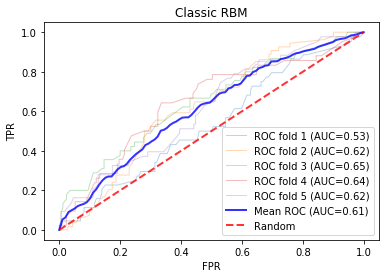

In [49]:
rbm = RBM(9, 100, 0.001, 10, 100)
run_cv(X_Full, rbm, 5, "Classic RBM")

Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done
Training model
Fitting L
Model Done


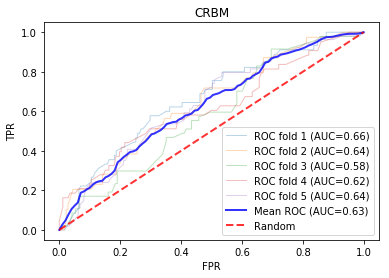

In [41]:
crbm = CRBM(3, 100, 6, 0.001, 10, 1000)
run_cv(X_Full, crbm, 5, "CRBM")

Training model
Epoch 0 - MSE: 0.4484496124031007
Epoch 1 - MSE: 0.43100775193798435
Epoch 2 - MSE: 0.42441860465116277
Epoch 3 - MSE: 0.44689922480620153
Epoch 4 - MSE: 0.4282945736434109
Epoch 5 - MSE: 0.43139534883720926
Epoch 6 - MSE: 0.44689922480620153
Epoch 7 - MSE: 0.4306201550387596
Epoch 8 - MSE: 0.45193798449612393
Epoch 9 - MSE: 0.43643410852713177
Epoch 10 - MSE: 0.43798449612403106
Epoch 11 - MSE: 0.4449612403100775
Epoch 12 - MSE: 0.43372093023255803
Epoch 13 - MSE: 0.42868217054263574
Epoch 14 - MSE: 0.4337209302325581
Epoch 15 - MSE: 0.4395348837209302
Epoch 16 - MSE: 0.44069767441860463
Epoch 17 - MSE: 0.43488372093023264
Epoch 18 - MSE: 0.4527131782945734
Epoch 19 - MSE: 0.43643410852713194
Epoch 20 - MSE: 0.4585271317829458
Epoch 21 - MSE: 0.4565891472868216
Epoch 22 - MSE: 0.4282945736434108
Epoch 23 - MSE: 0.42829457364341095
Epoch 24 - MSE: 0.43488372093023264
Epoch 25 - MSE: 0.4224806201550386
Epoch 26 - MSE: 0.42596899224806195
Epoch 27 - MSE: 0.4414728682170543

Epoch 29 - MSE: 0.4283524904214559
Epoch 30 - MSE: 0.42298850574712643
Epoch 31 - MSE: 0.4352490421455939
Epoch 32 - MSE: 0.43026819923371645
Epoch 33 - MSE: 0.41494252873563214
Epoch 34 - MSE: 0.41149425287356334
Epoch 35 - MSE: 0.42068965517241375
Epoch 36 - MSE: 0.42758620689655175
Epoch 37 - MSE: 0.42375478927203064
Epoch 38 - MSE: 0.4268199233716475
Epoch 39 - MSE: 0.4264367816091954
Epoch 40 - MSE: 0.4283524904214559
Epoch 41 - MSE: 0.4130268199233716
Epoch 42 - MSE: 0.43946360153256714
Epoch 43 - MSE: 0.43409961685823745
Epoch 44 - MSE: 0.4264367816091955
Epoch 45 - MSE: 0.42068965517241375
Epoch 46 - MSE: 0.4218390804597701
Epoch 47 - MSE: 0.42490421455938693
Epoch 48 - MSE: 0.43601532567049794
Epoch 49 - MSE: 0.43103448275862066
Fitting L
Model Done


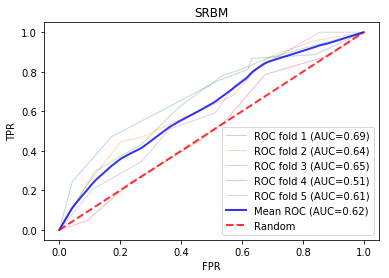

In [50]:
run_cv(X_Full, srbm, 5, "SRBM")

In [64]:
# Perform a 5-fold cross validation for a chosen model
def run_cv_autoencoder(X, chosen_model, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        # Train the model
        chosen_model.fit(Xt, Xt, epochs=500, batch_size=10)
        
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(chosen_model.predict(Xt), Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(chosen_model.predict(Xv))
        Yprob = lr.predict_proba(chosen_model.predict(Xv))
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

Epoch 1/500
860/860 [==============================] - 0s 26us/step - loss: 0.0017
Epoch 2/500
860/860 [==============================] - 0s 27us/step - loss: 0.0017
Epoch 3/500
860/860 [==============================] - 0s 28us/step - loss: 0.0017
Epoch 4/500
860/860 [==============================] - 0s 27us/step - loss: 0.0017
Epoch 5/500
860/860 [==============================] - 0s 31us/step - loss: 0.0016
Epoch 6/500
860/860 [==============================] - 0s 33us/step - loss: 0.0016
Epoch 7/500
860/860 [==============================] - 0s 28us/step - loss: 0.0017
Epoch 8/500
860/860 [==============================] - 0s 33us/step - loss: 0.0016
Epoch 9/500
860/860 [==============================] - 0s 29us/step - loss: 0.0016
Epoch 10/500
860/860 [==============================] - 0s 30us/step - loss: 0.0016
Epoch 11/500
860/860 [==============================] - 0s 28us/step - loss: 0.0016
Epoch 12/500
860/860 [==============================] - 0s 28us/step - loss: 0.0016
E

860/860 [==============================] - 0s 28us/step - loss: 9.5941e-04
Epoch 98/500
860/860 [==============================] - 0s 33us/step - loss: 9.4084e-04
Epoch 99/500
860/860 [==============================] - 0s 27us/step - loss: 9.5879e-04
Epoch 100/500
860/860 [==============================] - 0s 26us/step - loss: 9.2742e-04
Epoch 101/500
860/860 [==============================] - 0s 27us/step - loss: 9.2465e-04
Epoch 102/500
860/860 [==============================] - 0s 26us/step - loss: 9.5270e-04
Epoch 103/500
860/860 [==============================] - 0s 25us/step - loss: 9.0931e-04
Epoch 104/500
860/860 [==============================] - 0s 26us/step - loss: 9.1253e-04
Epoch 105/500
860/860 [==============================] - 0s 26us/step - loss: 9.1991e-04
Epoch 106/500
860/860 [==============================] - 0s 26us/step - loss: 9.2818e-04
Epoch 107/500
860/860 [==============================] - 0s 27us/step - loss: 9.1362e-04
Epoch 108/500
860/860 [==============

860/860 [==============================] - 0s 36us/step - loss: 5.8649e-04
Epoch 190/500
860/860 [==============================] - 0s 31us/step - loss: 5.6650e-04
Epoch 191/500
860/860 [==============================] - 0s 33us/step - loss: 5.7261e-04
Epoch 192/500
860/860 [==============================] - 0s 32us/step - loss: 5.6320e-04
Epoch 193/500
860/860 [==============================] - 0s 34us/step - loss: 5.6822e-04
Epoch 194/500
860/860 [==============================] - 0s 41us/step - loss: 5.6999e-04
Epoch 195/500
860/860 [==============================] - 0s 29us/step - loss: 5.6074e-04
Epoch 196/500
860/860 [==============================] - 0s 31us/step - loss: 5.6032e-04
Epoch 197/500
860/860 [==============================] - 0s 32us/step - loss: 5.5003e-04
Epoch 198/500
860/860 [==============================] - 0s 35us/step - loss: 5.5331e-04
Epoch 199/500
860/860 [==============================] - 0s 39us/step - loss: 5.4908e-04
Epoch 200/500
860/860 [============

860/860 [==============================] - 0s 24us/step - loss: 3.5379e-04
Epoch 281/500
860/860 [==============================] - 0s 26us/step - loss: 3.5528e-04
Epoch 282/500
860/860 [==============================] - 0s 32us/step - loss: 3.5102e-04
Epoch 283/500
860/860 [==============================] - 0s 25us/step - loss: 3.4796e-04
Epoch 284/500
860/860 [==============================] - 0s 25us/step - loss: 3.4754e-04
Epoch 285/500
860/860 [==============================] - 0s 27us/step - loss: 3.4716e-04
Epoch 286/500
860/860 [==============================] - 0s 27us/step - loss: 3.5295e-04
Epoch 287/500
860/860 [==============================] - 0s 24us/step - loss: 3.4683e-04
Epoch 288/500
860/860 [==============================] - 0s 31us/step - loss: 3.4625e-04
Epoch 289/500
860/860 [==============================] - 0s 27us/step - loss: 3.3910e-04
Epoch 290/500
860/860 [==============================] - 0s 25us/step - loss: 3.3864e-04
Epoch 291/500
860/860 [============

860/860 [==============================] - 0s 29us/step - loss: 2.1272e-04
Epoch 373/500
860/860 [==============================] - 0s 31us/step - loss: 2.0924e-04
Epoch 374/500
860/860 [==============================] - 0s 33us/step - loss: 2.1551e-04
Epoch 375/500
860/860 [==============================] - 0s 33us/step - loss: 2.0984e-04
Epoch 376/500
860/860 [==============================] - 0s 36us/step - loss: 2.1025e-04
Epoch 377/500
860/860 [==============================] - 0s 32us/step - loss: 2.0406e-04
Epoch 378/500
860/860 [==============================] - 0s 30us/step - loss: 2.0700e-04
Epoch 379/500
860/860 [==============================] - 0s 34us/step - loss: 2.0803e-04
Epoch 380/500
860/860 [==============================] - 0s 30us/step - loss: 2.0529e-04
Epoch 381/500
860/860 [==============================] - 0s 31us/step - loss: 2.0335e-04
Epoch 382/500
860/860 [==============================] - 0s 31us/step - loss: 2.0099e-04
Epoch 383/500
860/860 [============

860/860 [==============================] - 0s 29us/step - loss: 1.2707e-04
Epoch 465/500
860/860 [==============================] - 0s 35us/step - loss: 1.2372e-04
Epoch 466/500
860/860 [==============================] - 0s 34us/step - loss: 1.2554e-04
Epoch 467/500
860/860 [==============================] - 0s 35us/step - loss: 1.2418e-04
Epoch 468/500
860/860 [==============================] - 0s 33us/step - loss: 1.2233e-04
Epoch 469/500
860/860 [==============================] - 0s 34us/step - loss: 1.2157e-04
Epoch 470/500
860/860 [==============================] - 0s 31us/step - loss: 1.2129e-04
Epoch 471/500
860/860 [==============================] - 0s 32us/step - loss: 1.1925e-04
Epoch 472/500
860/860 [==============================] - 0s 36us/step - loss: 1.1917e-04
Epoch 473/500
860/860 [==============================] - 0s 31us/step - loss: 1.2213e-04
Epoch 474/500
860/860 [==============================] - 0s 33us/step - loss: 1.1662e-04
Epoch 475/500
860/860 [============

Epoch 57/500
861/861 [==============================] - 0s 38us/step - loss: 9.8861e-05
Epoch 58/500
861/861 [==============================] - 0s 35us/step - loss: 9.8470e-05
Epoch 59/500
861/861 [==============================] - 0s 32us/step - loss: 9.6765e-05
Epoch 60/500
861/861 [==============================] - 0s 38us/step - loss: 9.5383e-05
Epoch 61/500
861/861 [==============================] - 0s 35us/step - loss: 9.5600e-05
Epoch 62/500
861/861 [==============================] - 0s 33us/step - loss: 9.7885e-05
Epoch 63/500
861/861 [==============================] - 0s 29us/step - loss: 9.5778e-05
Epoch 64/500
861/861 [==============================] - 0s 29us/step - loss: 9.3700e-05
Epoch 65/500
861/861 [==============================] - 0s 31us/step - loss: 9.3986e-05
Epoch 66/500
861/861 [==============================] - 0s 32us/step - loss: 9.3016e-05
Epoch 67/500
861/861 [==============================] - 0s 32us/step - loss: 9.1813e-05
Epoch 68/500
861/861 [==========

861/861 [==============================] - 0s 35us/step - loss: 4.8017e-05
Epoch 150/500
861/861 [==============================] - 0s 30us/step - loss: 4.7849e-05
Epoch 151/500
861/861 [==============================] - 0s 30us/step - loss: 4.7246e-05
Epoch 152/500
861/861 [==============================] - 0s 32us/step - loss: 4.6541e-05
Epoch 153/500
861/861 [==============================] - 0s 27us/step - loss: 4.6352e-05
Epoch 154/500
861/861 [==============================] - 0s 27us/step - loss: 4.6232e-05
Epoch 155/500
861/861 [==============================] - 0s 31us/step - loss: 4.5996e-05
Epoch 156/500
861/861 [==============================] - 0s 30us/step - loss: 4.6217e-05
Epoch 157/500
861/861 [==============================] - 0s 31us/step - loss: 4.5649e-05
Epoch 158/500
861/861 [==============================] - 0s 28us/step - loss: 4.4753e-05
Epoch 159/500
861/861 [==============================] - 0s 32us/step - loss: 4.4963e-05
Epoch 160/500
861/861 [============

861/861 [==============================] - 0s 29us/step - loss: 2.3625e-05
Epoch 241/500
861/861 [==============================] - 0s 33us/step - loss: 2.3140e-05
Epoch 242/500
861/861 [==============================] - 0s 33us/step - loss: 2.2915e-05
Epoch 243/500
861/861 [==============================] - 0s 31us/step - loss: 2.2967e-05
Epoch 244/500
861/861 [==============================] - 0s 31us/step - loss: 2.2531e-05
Epoch 245/500
861/861 [==============================] - 0s 30us/step - loss: 2.2576e-05
Epoch 246/500
861/861 [==============================] - 0s 28us/step - loss: 2.3024e-05
Epoch 247/500
861/861 [==============================] - 0s 32us/step - loss: 2.2436e-05
Epoch 248/500
861/861 [==============================] - 0s 34us/step - loss: 2.1975e-05
Epoch 249/500
861/861 [==============================] - 0s 29us/step - loss: 2.1943e-05
Epoch 250/500
861/861 [==============================] - 0s 32us/step - loss: 2.1428e-05
Epoch 251/500
861/861 [============

861/861 [==============================] - 0s 29us/step - loss: 1.0752e-05
Epoch 333/500
861/861 [==============================] - 0s 32us/step - loss: 1.0700e-05
Epoch 334/500
861/861 [==============================] - 0s 29us/step - loss: 1.0772e-05
Epoch 335/500
861/861 [==============================] - 0s 28us/step - loss: 1.0560e-05
Epoch 336/500
861/861 [==============================] - 0s 29us/step - loss: 1.0373e-05
Epoch 337/500
861/861 [==============================] - 0s 30us/step - loss: 1.0322e-05
Epoch 338/500
861/861 [==============================] - 0s 32us/step - loss: 1.0375e-05
Epoch 339/500
861/861 [==============================] - 0s 29us/step - loss: 1.0330e-05
Epoch 340/500
861/861 [==============================] - 0s 30us/step - loss: 1.0178e-05
Epoch 341/500
861/861 [==============================] - 0s 30us/step - loss: 1.0015e-05
Epoch 342/500
861/861 [==============================] - 0s 31us/step - loss: 9.9436e-06
Epoch 343/500
861/861 [============

861/861 [==============================] - 0s 26us/step - loss: 4.9969e-06
Epoch 425/500
861/861 [==============================] - 0s 29us/step - loss: 4.9375e-06
Epoch 426/500
861/861 [==============================] - 0s 27us/step - loss: 4.9089e-06
Epoch 427/500
861/861 [==============================] - 0s 27us/step - loss: 4.8673e-06
Epoch 428/500
861/861 [==============================] - 0s 27us/step - loss: 4.7409e-06
Epoch 429/500
861/861 [==============================] - 0s 28us/step - loss: 4.6949e-06
Epoch 430/500
861/861 [==============================] - 0s 28us/step - loss: 4.7197e-06
Epoch 431/500
861/861 [==============================] - 0s 28us/step - loss: 4.7046e-06
Epoch 432/500
861/861 [==============================] - 0s 29us/step - loss: 4.5977e-06
Epoch 433/500
861/861 [==============================] - 0s 27us/step - loss: 4.5975e-06
Epoch 434/500
861/861 [==============================] - 0s 26us/step - loss: 4.5246e-06
Epoch 435/500
861/861 [============

861/861 [==============================] - 0s 28us/step - loss: 1.8308e-05
Epoch 17/500
861/861 [==============================] - 0s 28us/step - loss: 1.7414e-05
Epoch 18/500
861/861 [==============================] - 0s 28us/step - loss: 1.6864e-05
Epoch 19/500
861/861 [==============================] - 0s 28us/step - loss: 1.6314e-05
Epoch 20/500
861/861 [==============================] - 0s 28us/step - loss: 1.6013e-05
Epoch 21/500
861/861 [==============================] - 0s 28us/step - loss: 1.5489e-05
Epoch 22/500
861/861 [==============================] - 0s 29us/step - loss: 1.5088e-05
Epoch 23/500
861/861 [==============================] - 0s 30us/step - loss: 1.4838e-05
Epoch 24/500
861/861 [==============================] - 0s 29us/step - loss: 1.4489e-05
Epoch 25/500
861/861 [==============================] - 0s 29us/step - loss: 1.4038e-05
Epoch 26/500
861/861 [==============================] - 0s 28us/step - loss: 1.3839e-05
Epoch 27/500
861/861 [=======================

861/861 [==============================] - 0s 29us/step - loss: 3.9085e-06
Epoch 110/500
861/861 [==============================] - 0s 29us/step - loss: 3.8303e-06
Epoch 111/500
861/861 [==============================] - 0s 29us/step - loss: 3.7764e-06
Epoch 112/500
861/861 [==============================] - 0s 29us/step - loss: 3.7190e-06
Epoch 113/500
861/861 [==============================] - 0s 32us/step - loss: 3.6721e-06
Epoch 114/500
861/861 [==============================] - 0s 28us/step - loss: 3.6458e-06
Epoch 115/500
861/861 [==============================] - 0s 34us/step - loss: 3.5510e-06
Epoch 116/500
861/861 [==============================] - 0s 34us/step - loss: 3.4875e-06
Epoch 117/500
861/861 [==============================] - 0s 33us/step - loss: 3.4716e-06
Epoch 118/500
861/861 [==============================] - 0s 25us/step - loss: 3.4197e-06
Epoch 119/500
861/861 [==============================] - 0s 32us/step - loss: 3.3435e-06
Epoch 120/500
861/861 [============

861/861 [==============================] - 0s 28us/step - loss: 1.2960e-06
Epoch 201/500
861/861 [==============================] - 0s 29us/step - loss: 1.2883e-06
Epoch 202/500
861/861 [==============================] - 0s 28us/step - loss: 1.2954e-06
Epoch 203/500
861/861 [==============================] - 0s 28us/step - loss: 1.2695e-06
Epoch 204/500
861/861 [==============================] - 0s 27us/step - loss: 1.2510e-06
Epoch 205/500
861/861 [==============================] - 0s 27us/step - loss: 1.3222e-06
Epoch 206/500
861/861 [==============================] - 0s 29us/step - loss: 1.2072e-06
Epoch 207/500
861/861 [==============================] - 0s 31us/step - loss: 1.2023e-06
Epoch 208/500
861/861 [==============================] - 0s 31us/step - loss: 1.1859e-06
Epoch 209/500
861/861 [==============================] - 0s 30us/step - loss: 1.1898e-06
Epoch 210/500
861/861 [==============================] - 0s 31us/step - loss: 1.1682e-06
Epoch 211/500
861/861 [============

861/861 [==============================] - 0s 33us/step - loss: 5.6530e-07
Epoch 292/500
861/861 [==============================] - 0s 35us/step - loss: 5.6743e-07
Epoch 293/500
861/861 [==============================] - 0s 33us/step - loss: 5.7017e-07
Epoch 294/500
861/861 [==============================] - 0s 29us/step - loss: 5.6008e-07
Epoch 295/500
861/861 [==============================] - 0s 33us/step - loss: 5.5481e-07
Epoch 296/500
861/861 [==============================] - 0s 33us/step - loss: 5.4941e-07
Epoch 297/500
861/861 [==============================] - 0s 37us/step - loss: 5.4884e-07
Epoch 298/500
861/861 [==============================] - 0s 31us/step - loss: 5.4876e-07
Epoch 299/500
861/861 [==============================] - 0s 30us/step - loss: 5.3864e-07
Epoch 300/500
861/861 [==============================] - 0s 35us/step - loss: 5.3873e-07
Epoch 301/500
861/861 [==============================] - 0s 34us/step - loss: 5.2961e-07
Epoch 302/500
861/861 [============

861/861 [==============================] - 0s 33us/step - loss: 3.3761e-07
Epoch 383/500
861/861 [==============================] - 0s 32us/step - loss: 3.4326e-07
Epoch 384/500
861/861 [==============================] - 0s 32us/step - loss: 3.3485e-07
Epoch 385/500
861/861 [==============================] - 0s 28us/step - loss: 3.3221e-07
Epoch 386/500
861/861 [==============================] - 0s 28us/step - loss: 3.3453e-07
Epoch 387/500
861/861 [==============================] - 0s 32us/step - loss: 3.3428e-07
Epoch 388/500
861/861 [==============================] - 0s 30us/step - loss: 3.3302e-07
Epoch 389/500
861/861 [==============================] - 0s 42us/step - loss: 3.2992e-07
Epoch 390/500
861/861 [==============================] - 0s 42us/step - loss: 3.2321e-07
Epoch 391/500
861/861 [==============================] - 0s 35us/step - loss: 3.2325e-07
Epoch 392/500
861/861 [==============================] - 0s 36us/step - loss: 3.2178e-07
Epoch 393/500
861/861 [============

861/861 [==============================] - 0s 31us/step - loss: 2.4042e-07
Epoch 475/500
861/861 [==============================] - 0s 29us/step - loss: 2.3884e-07
Epoch 476/500
861/861 [==============================] - 0s 27us/step - loss: 2.3687e-07
Epoch 477/500
861/861 [==============================] - 0s 28us/step - loss: 2.3671e-07
Epoch 478/500
861/861 [==============================] - 0s 27us/step - loss: 2.3640e-07
Epoch 479/500
861/861 [==============================] - 0s 29us/step - loss: 2.3702e-07
Epoch 480/500
861/861 [==============================] - 0s 35us/step - loss: 2.3623e-07
Epoch 481/500
861/861 [==============================] - 0s 38us/step - loss: 2.3502e-07
Epoch 482/500
861/861 [==============================] - 0s 31us/step - loss: 2.3217e-07
Epoch 483/500
861/861 [==============================] - 0s 36us/step - loss: 2.3557e-07
Epoch 484/500
861/861 [==============================] - 0s 38us/step - loss: 2.3222e-07
Epoch 485/500
861/861 [============

861/861 [==============================] - 0s 35us/step - loss: 1.3141e-06
Epoch 68/500
861/861 [==============================] - 0s 36us/step - loss: 1.2977e-06
Epoch 69/500
861/861 [==============================] - 0s 36us/step - loss: 1.2506e-06
Epoch 70/500
861/861 [==============================] - 0s 32us/step - loss: 1.2428e-06
Epoch 71/500
861/861 [==============================] - 0s 36us/step - loss: 1.2464e-06
Epoch 72/500
861/861 [==============================] - 0s 31us/step - loss: 1.1972e-06
Epoch 73/500
861/861 [==============================] - 0s 31us/step - loss: 1.1922e-06
Epoch 74/500
861/861 [==============================] - 0s 34us/step - loss: 1.1727e-06
Epoch 75/500
861/861 [==============================] - 0s 33us/step - loss: 1.1527e-06
Epoch 76/500
861/861 [==============================] - 0s 33us/step - loss: 1.1178e-06
Epoch 77/500
861/861 [==============================] - 0s 32us/step - loss: 1.1319e-06
Epoch 78/500
861/861 [=======================

861/861 [==============================] - 0s 30us/step - loss: 4.6160e-07
Epoch 160/500
861/861 [==============================] - 0s 27us/step - loss: 4.6528e-07
Epoch 161/500
861/861 [==============================] - 0s 26us/step - loss: 4.5531e-07
Epoch 162/500
861/861 [==============================] - 0s 26us/step - loss: 4.5554e-07
Epoch 163/500
861/861 [==============================] - 0s 26us/step - loss: 4.5299e-07
Epoch 164/500
861/861 [==============================] - 0s 31us/step - loss: 4.6022e-07
Epoch 165/500
861/861 [==============================] - 0s 31us/step - loss: 4.5082e-07
Epoch 166/500
861/861 [==============================] - 0s 27us/step - loss: 4.3887e-07
Epoch 167/500
861/861 [==============================] - 0s 28us/step - loss: 4.4322e-07
Epoch 168/500
861/861 [==============================] - 0s 27us/step - loss: 4.4591e-07
Epoch 169/500
861/861 [==============================] - 0s 26us/step - loss: 4.4181e-07
Epoch 170/500
861/861 [============

861/861 [==============================] - 0s 28us/step - loss: 2.9113e-07
Epoch 252/500
861/861 [==============================] - 0s 37us/step - loss: 2.8869e-07
Epoch 253/500
861/861 [==============================] - 0s 30us/step - loss: 3.0656e-07
Epoch 254/500
861/861 [==============================] - 0s 29us/step - loss: 2.8696e-07
Epoch 255/500
861/861 [==============================] - 0s 30us/step - loss: 2.9059e-07
Epoch 256/500
861/861 [==============================] - 0s 30us/step - loss: 2.9051e-07
Epoch 257/500
861/861 [==============================] - ETA: 0s - loss: 1.3560e-0 - 0s 31us/step - loss: 2.8722e-07
Epoch 258/500
861/861 [==============================] - 0s 31us/step - loss: 2.8068e-07
Epoch 259/500
861/861 [==============================] - 0s 32us/step - loss: 2.7968e-07
Epoch 260/500
861/861 [==============================] - 0s 31us/step - loss: 2.7693e-07
Epoch 261/500
861/861 [==============================] - 0s 30us/step - loss: 2.8234e-07
Epoch 2

861/861 [==============================] - 0s 33us/step - loss: 2.2159e-07
Epoch 343/500
861/861 [==============================] - 0s 33us/step - loss: 2.1734e-07
Epoch 344/500
861/861 [==============================] - 0s 35us/step - loss: 2.6428e-07
Epoch 345/500
861/861 [==============================] - 0s 32us/step - loss: 2.2386e-07
Epoch 346/500
861/861 [==============================] - 0s 36us/step - loss: 2.1861e-07
Epoch 347/500
861/861 [==============================] - 0s 32us/step - loss: 2.1581e-07
Epoch 348/500
861/861 [==============================] - 0s 33us/step - loss: 2.1945e-07
Epoch 349/500
861/861 [==============================] - 0s 39us/step - loss: 2.1462e-07
Epoch 350/500
861/861 [==============================] - 0s 33us/step - loss: 2.1432e-07
Epoch 351/500
861/861 [==============================] - 0s 35us/step - loss: 2.1251e-07
Epoch 352/500
861/861 [==============================] - 0s 30us/step - loss: 2.1248e-07
Epoch 353/500
861/861 [============

861/861 [==============================] - 0s 31us/step - loss: 1.8385e-07
Epoch 435/500
861/861 [==============================] - 0s 32us/step - loss: 1.7865e-07
Epoch 436/500
861/861 [==============================] - 0s 30us/step - loss: 1.7965e-07
Epoch 437/500
861/861 [==============================] - ETA: 0s - loss: 1.5464e-0 - 0s 29us/step - loss: 1.7911e-07
Epoch 438/500
861/861 [==============================] - 0s 32us/step - loss: 1.7781e-07
Epoch 439/500
861/861 [==============================] - 0s 29us/step - loss: 1.7708e-07
Epoch 440/500
861/861 [==============================] - 0s 31us/step - loss: 1.7662e-07
Epoch 441/500
861/861 [==============================] - 0s 32us/step - loss: 1.7728e-07
Epoch 442/500
861/861 [==============================] - 0s 29us/step - loss: 1.7787e-07
Epoch 443/500
861/861 [==============================] - 0s 31us/step - loss: 1.7692e-07
Epoch 444/500
861/861 [==============================] - 0s 32us/step - loss: 1.7554e-07
Epoch 4

861/861 [==============================] - 0s 26us/step - loss: 3.2321e-07
Epoch 27/500
861/861 [==============================] - 0s 26us/step - loss: 3.1185e-07
Epoch 28/500
861/861 [==============================] - 0s 26us/step - loss: 3.0215e-07
Epoch 29/500
861/861 [==============================] - 0s 29us/step - loss: 2.9501e-07
Epoch 30/500
861/861 [==============================] - 0s 25us/step - loss: 2.8656e-07
Epoch 31/500
861/861 [==============================] - 0s 29us/step - loss: 2.8229e-07
Epoch 32/500
861/861 [==============================] - 0s 32us/step - loss: 2.7359e-07
Epoch 33/500
861/861 [==============================] - 0s 32us/step - loss: 2.6688e-07
Epoch 34/500
861/861 [==============================] - 0s 35us/step - loss: 2.6157e-07
Epoch 35/500
861/861 [==============================] - 0s 37us/step - loss: 2.5595e-07
Epoch 36/500
861/861 [==============================] - 0s 37us/step - loss: 2.5127e-07
Epoch 37/500
861/861 [=======================

861/861 [==============================] - 0s 32us/step - loss: 1.5572e-07
Epoch 120/500
861/861 [==============================] - 0s 29us/step - loss: 1.5441e-07
Epoch 121/500
861/861 [==============================] - 0s 31us/step - loss: 1.5525e-07
Epoch 122/500
861/861 [==============================] - 0s 31us/step - loss: 1.5549e-07
Epoch 123/500
861/861 [==============================] - 0s 29us/step - loss: 1.5464e-07
Epoch 124/500
861/861 [==============================] - 0s 32us/step - loss: 1.5453e-07
Epoch 125/500
861/861 [==============================] - 0s 30us/step - loss: 1.5345e-07
Epoch 126/500
861/861 [==============================] - 0s 29us/step - loss: 1.5491e-07
Epoch 127/500
861/861 [==============================] - 0s 30us/step - loss: 1.5343e-07
Epoch 128/500
861/861 [==============================] - 0s 33us/step - loss: 1.5377e-07
Epoch 129/500
861/861 [==============================] - 0s 34us/step - loss: 1.5302e-07
Epoch 130/500
861/861 [============

861/861 [==============================] - 0s 32us/step - loss: 1.4387e-07
Epoch 212/500
861/861 [==============================] - 0s 34us/step - loss: 1.4448e-07
Epoch 213/500
861/861 [==============================] - 0s 29us/step - loss: 1.4412e-07
Epoch 214/500
861/861 [==============================] - 0s 30us/step - loss: 1.4358e-07
Epoch 215/500
861/861 [==============================] - 0s 33us/step - loss: 1.4347e-07
Epoch 216/500
861/861 [==============================] - 0s 29us/step - loss: 1.4414e-07
Epoch 217/500
861/861 [==============================] - 0s 34us/step - loss: 1.4281e-07
Epoch 218/500
861/861 [==============================] - 0s 29us/step - loss: 1.4318e-07
Epoch 219/500
861/861 [==============================] - 0s 31us/step - loss: 1.4268e-07
Epoch 220/500
861/861 [==============================] - 0s 29us/step - loss: 1.4372e-07
Epoch 221/500
861/861 [==============================] - 0s 31us/step - loss: 1.4242e-07
Epoch 222/500
861/861 [============

861/861 [==============================] - 0s 26us/step - loss: 1.3642e-07
Epoch 304/500
861/861 [==============================] - 0s 31us/step - loss: 1.3703e-07
Epoch 305/500
861/861 [==============================] - 0s 32us/step - loss: 1.3638e-07
Epoch 306/500
861/861 [==============================] - 0s 28us/step - loss: 1.3627e-07
Epoch 307/500
861/861 [==============================] - 0s 32us/step - loss: 1.3616e-07
Epoch 308/500
861/861 [==============================] - 0s 28us/step - loss: 1.3653e-07
Epoch 309/500
861/861 [==============================] - 0s 32us/step - loss: 1.3587e-07
Epoch 310/500
861/861 [==============================] - 0s 31us/step - loss: 1.3648e-07
Epoch 311/500
861/861 [==============================] - 0s 36us/step - loss: 1.3610e-07
Epoch 312/500
861/861 [==============================] - 0s 113us/step - loss: 1.3603e-07
Epoch 313/500
861/861 [==============================] - 0s 51us/step - loss: 1.3573e-07
Epoch 314/500
861/861 [===========

861/861 [==============================] - 0s 27us/step - loss: 1.3162e-07
Epoch 396/500
861/861 [==============================] - 0s 33us/step - loss: 1.3153e-07
Epoch 397/500
861/861 [==============================] - 0s 32us/step - loss: 1.3139e-07
Epoch 398/500
861/861 [==============================] - ETA: 0s - loss: 1.1195e-0 - 0s 31us/step - loss: 1.3158e-07
Epoch 399/500
861/861 [==============================] - 0s 32us/step - loss: 1.3150e-07
Epoch 400/500
861/861 [==============================] - 0s 31us/step - loss: 1.3131e-07
Epoch 401/500
861/861 [==============================] - 0s 34us/step - loss: 1.3139e-07
Epoch 402/500
861/861 [==============================] - 0s 31us/step - loss: 1.3195e-07
Epoch 403/500
861/861 [==============================] - 0s 32us/step - loss: 1.3116e-07
Epoch 404/500
861/861 [==============================] - 0s 30us/step - loss: 1.3133e-07
Epoch 405/500
861/861 [==============================] - 0s 41us/step - loss: 1.3125e-07
Epoch 4

861/861 [==============================] - 0s 27us/step - loss: 1.2821e-07
Epoch 487/500
861/861 [==============================] - 0s 27us/step - loss: 1.2795e-07
Epoch 488/500
861/861 [==============================] - 0s 27us/step - loss: 1.2782e-07
Epoch 489/500
861/861 [==============================] - 0s 29us/step - loss: 1.2774e-07
Epoch 490/500
861/861 [==============================] - 0s 27us/step - loss: 1.2786e-07
Epoch 491/500
861/861 [==============================] - 0s 30us/step - loss: 1.2783e-07
Epoch 492/500
861/861 [==============================] - 0s 33us/step - loss: 1.2796e-07
Epoch 493/500
861/861 [==============================] - 0s 29us/step - loss: 1.2745e-07
Epoch 494/500
861/861 [==============================] - 0s 29us/step - loss: 1.2744e-07
Epoch 495/500
861/861 [==============================] - 0s 28us/step - loss: 1.2771e-07
Epoch 496/500
861/861 [==============================] - 0s 35us/step - loss: 1.2782e-07
Epoch 497/500
861/861 [============

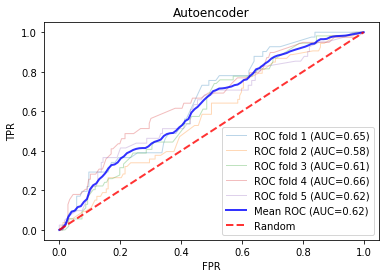

In [65]:
run_cv_autoencoder(X_Full, autoencoder, 5, "Autoencoder")

In [66]:
# Perform a 5-fold cross validation for a chosen model
def run_cv_no_model(X, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(Xt, Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(Xv)
        Yprob = lr.predict_proba(Xv)
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

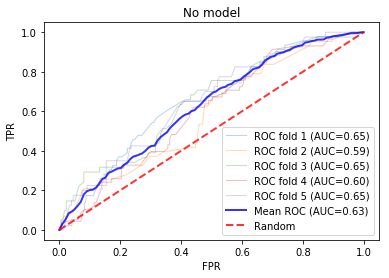

In [67]:
run_cv_no_model(X_Full, 5, "No model")